In [8]:
# ✅ Import TensorFlow – the main deep learning library used to build and train models.
import tensorflow as tf

# ✅ Import tensorflow_datasets – gives access to many pre-built datasets including Oxford Pets.
import tensorflow_datasets as tfds

# ✅ Import matplotlib – used to show images, masks, and graphs (like training accuracy/loss).
import matplotlib.pyplot as plt

# ✅ Import numpy – a helpful math library often used with image data (e.g., reshaping arrays).
import numpy as np


**Purpose of the Code below
📦 Load the Oxford Pets dataset

🧼 Clean and prepare images and masks for training

⚡ Optimize the data pipeline (faster and memory-efficient)

✅ Ready the data for use in a neural network**

In [71]:

# 📏 Set the image size all images and masks will be resized to
IMG_SIZE = 128

# 📦 Load the Oxford-IIIT Pet dataset from TensorFlow Datasets
# info gives metadata like number of examples, labels, etc.
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

# 🧪 Split the dataset into training and testing parts
train_dataset = dataset['train']
test_dataset = dataset['test']

# 🧼 Define a function to normalize the images and clean the masks
def normalize_img(datapoint):
    # Convert image pixel values from integers (0–255) to floats (0–1)
    image = tf.cast(datapoint['image'], tf.float32) / 255.0

    # Convert segmentation mask to float for processing
    mask = tf.cast(datapoint['segmentation_mask'], tf.float32)

    # 🎯 Keep only label 1 (the pet), set all others (background, border) to 0
    # This makes it a binary segmentation task: Pet = 1, Not pet = 0
    mask = tf.where(mask == 1.0, 1.0, 0.0)

    return image, mask


# 🔁 Resize function for both image and mask
def resize(input_image, input_mask):
    # Resize image to target size using bilinear interpolation (default)
    input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE))

    # Resize the mask using NEAREST NEIGHBOR to preserve class labels (no in-between values)
    input_mask = tf.image.resize(input_mask, (IMG_SIZE, IMG_SIZE), method='nearest')

    # Remove unnecessary extra dimensions (e.g., from (128,128,1,1) → (128,128))
    input_mask = tf.squeeze(input_mask)

    # Add one channel back (so shape becomes (128,128,1)) for model compatibility
    input_mask = tf.expand_dims(input_mask, axis=-1)

    return input_image, input_mask


# 🔧 Prepare the training dataset with preprocessing steps
train_dataset = (
    train_dataset
    .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)  # Normalize all images and masks
    .map(resize, num_parallel_calls=tf.data.AUTOTUNE)         # Resize them to 128x128
    .cache()                                                  # Cache in memory for speed
    .shuffle(1000)                                            # Shuffle dataset for better training
    .batch(32)                                                # Group 32 examples into one batch
    .prefetch(tf.data.AUTOTUNE)                               # Prepare next batch in background
)

# 🧪 Prepare the test dataset similarly (no shuffling or caching needed)
test_dataset = (
    test_dataset
    .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    .map(resize, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)



In [64]:
for image, mask in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)


Image shape: (32, 128, 128, 3)
Mask shape: (32, 128, 128, 1)


** 🧠 Purpose of This Code
This code builds a U-Net model for binary image segmentation (e.g., pet vs background).
U-Net is good at both:

Understanding what is in the image (deep features)

Where it is (preserves spatial info using skip connections) **

In [65]:
# 📦 Import layers and model-building tools from Keras
from tensorflow.keras import layers, models

# 🏗️ Define a function to build the U-Net model
def unet_model(input_size=(128, 128, 3)):
    # 👁️ Input layer — takes in 128x128 RGB image (3 channels)
    inputs = tf.keras.Input(input_size)

    # ===========================
    # 🔽 Encoder (Downsampling Path)
    # ===========================

    # 🧱 Block 1: Two convolutions with 64 filters
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)  # Downsample by 2x

    # 🧱 Block 2
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # 🧱 Block 3
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # ===========================
    # 🔁 Bottleneck (Middle of the "U")
    # ===========================

    # 🧠 Deepest layer — most abstract features
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)

    # ===========================
    # 🔼 Decoder (Upsampling Path)
    # ===========================

    # 🔄 Block 5 — upsample and concatenate with features from encoder block 3
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)

    # 🔄 Block 6 — upsample and concatenate with encoder block 2
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)

    # 🔄 Block 7 — upsample and concatenate with encoder block 1
    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)

    # ===========================
    # 🎯 Output Layer
    # ===========================

    # Final 1x1 convolution to reduce to 1 output channel (binary segmentation)
    # Sigmoid gives probabilities (values between 0 and 1)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)

    # 🧱 Create the full model from input to output
    model = models.Model(inputs, outputs, name='unet')

    return model



In [66]:
# Create the model by calling the function.
model = unet_model()

In [67]:
#Prepare the model for training:

#adam optimizer adjusts weights smartly
#binary_crossentropy is used for 0/1 segmentation masks
#Track accuracy while training

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [68]:
# Print a summary showing all layers, shapes, and parameters.
model.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_15[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_17[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_19[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_5[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_21[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 768)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │  1,769,728 │ concatenate_3[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 64, 64,    │          0 │ conv2d_24[0][0] 

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
for data in train_dataset.take(1):
    print(type(data), len(data))


<class 'tuple'> 2


In [72]:
for images, masks in train_dataset.take(1):
    print("Image shape:", images.shape)
    print("Mask shape:", masks.shape)
    print("Image dtype:", images.dtype)
    print("Mask dtype:", masks.dtype)
    print("Mask unique values:", tf.unique(tf.reshape(masks, [-1]))[0].numpy())


Image shape: (32, 128, 128, 3)
Mask shape: (32, 128, 128, 1)
Image dtype: <dtype: 'float32'>
Mask dtype: <dtype: 'float32'>
Mask unique values: [0. 1.]


In [75]:
#Sets the number of training loops (epochs) to 5.
#An epoch means the model will see all training data once.
EPOCHS=5

#Starts training the model:
#train_dataset: the data used for learning.
#validation_data=test_dataset: used to check accuracy after each epoch (but not used for learning).
#epochs=EPOCHS: train for 5 full rounds over the dataset
history = model.fit(train_dataset,validation_data=test_dataset,epochs=EPOCHS)


Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 50s 431ms/step - accuracy: 0.8270 - loss: 0.3802 - val_accuracy: 0.8589 - val_loss: 0.3195
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 89s 489ms/step - accuracy: 0.8572 - loss: 0.3262 - val_accuracy: 0.8714 - val_loss: 0.2947
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 48s 420ms/step - accuracy: 0.8730 - loss: 0.2926 - val_accuracy: 0.8874 - val_loss: 0.2639
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 56s 487ms/step - accuracy: 0.8873 - loss: 0.2630 - val_accuracy: 0.8777 - val_loss: 0.2849
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 56s 488ms/step - accuracy: 0.8892 - loss: 0.2617 - val_accuracy: 0.8780 - val_loss: 0.2879


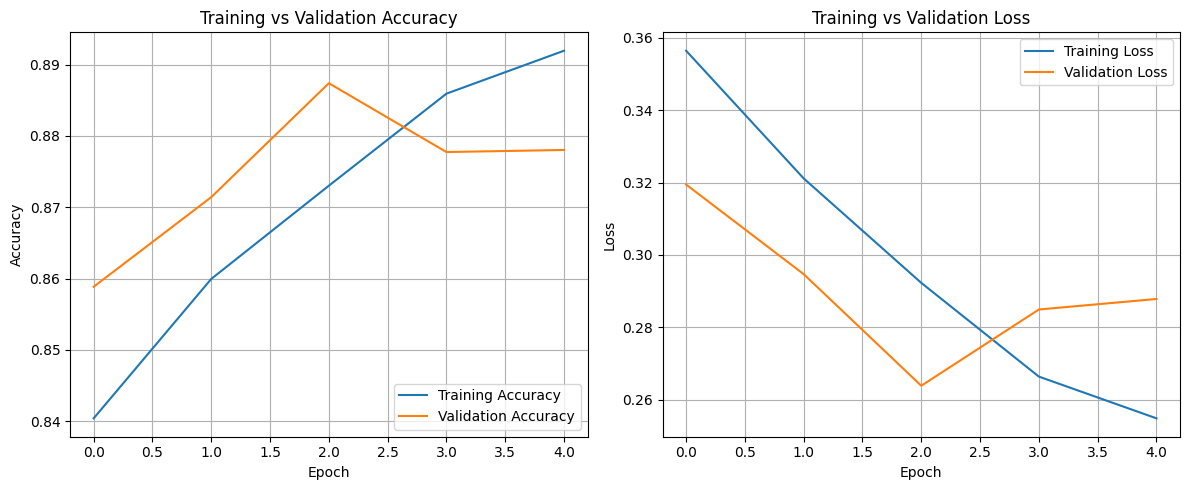

In [76]:
import matplotlib.pyplot as plt

# Get data from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


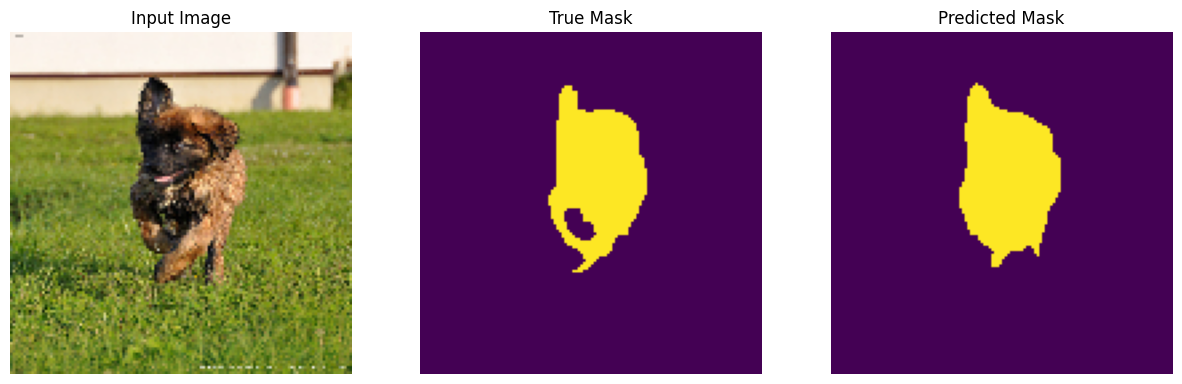

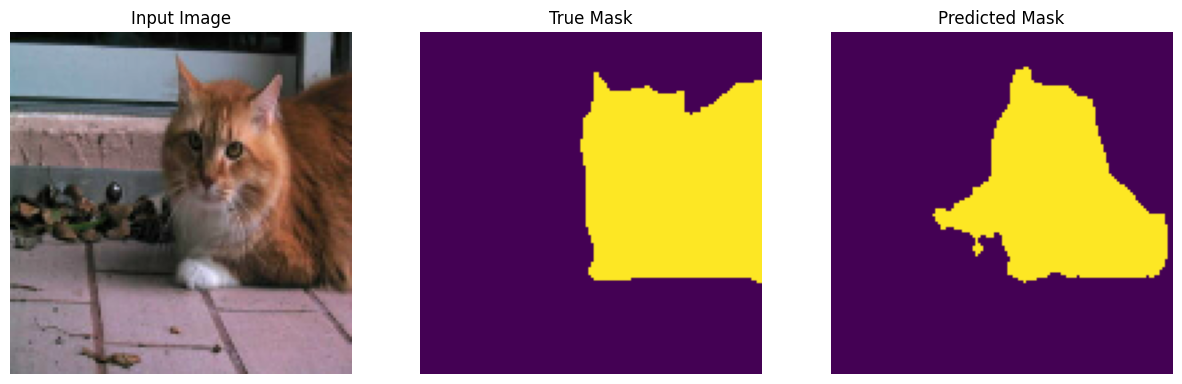

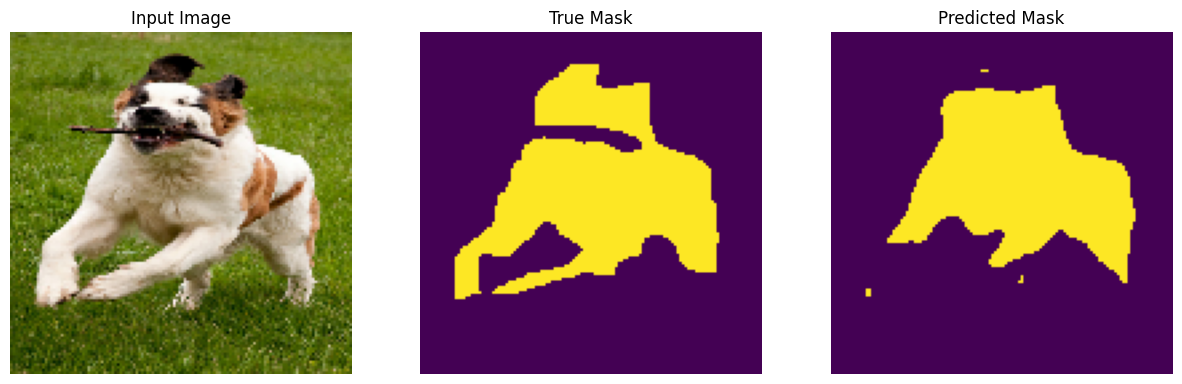

In [77]:
def display(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in test_dataset.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.round(pred_mask)
    for i in range(3):
        display([image[i], mask[i], pred_mask[i]])